## Libraries

In [91]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
# import plotly.express as px

## Constants

In [92]:
file_path = "mpu6050_data.csv" 
filtered_file_path = "mpu6050_filtered_kalman.csv"
output_file = "mpu6050_filtered_adaptive.csv"

## Loading the data

In [93]:
df = pd.read_csv(file_path)
df

,timestamp,yaw,pitch,roll,ax,ay,az
0,0.002043,-0.44,0.03,0.01,-32,88,-42
1,0.002043,-0.44,0.03,0.01,7,12,-26
2,0.002043,-0.44,0.03,-0.00,-107,-27,5
3,0.002043,-0.44,0.03,-0.00,-21,30,17
4,0.002043,-0.44,0.03,0.01,-32,88,-42
...,...,...,...,...,...,...,...
623,9.953192,-18.93,0.14,0.07,22,18,203
624,9.971229,-18.93,0.14,0.07,70,-61,-140
625,9.987644,-18.94,0.15,0.07,-69,62,-4
626,9.995538,-18.94,0.14,0.07,14,10,-8


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  628 non-null    float64
 1   yaw        628 non-null    float64
 2   pitch      628 non-null    float64
 3   roll       628 non-null    float64
 4   ax         628 non-null    int64  
 5   ay         628 non-null    int64  
 6   az         628 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 34.5 KB


## Basic Statistics

In [95]:
df.drop("timestamp", axis=1).describe()

,yaw,pitch,roll,ax,ay,az
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,-10.706115,0.163455,0.064682,-5.769108,-6.240446,-9.949045
std,9.422637,0.265519,0.067036,608.269650,164.910486,101.083385
min,-18.940000,-0.420000,-0.130000,-4139.000000,-1762.000000,-605.000000
25%,-18.930000,0.030000,0.010000,-31.250000,-36.000000,-58.000000
50%,-18.920000,0.140000,0.070000,6.000000,-1.000000,-14.500000
75%,-0.420000,0.170000,0.090000,37.000000,36.000000,32.250000
max,5.100000,1.460000,0.320000,9207.000000,791.000000,977.000000


In [96]:
columns_to_filter = df.columns.to_list()[1:]
columns_to_filter

['yaw', 'pitch', 'roll', 'ax', 'ay', 'az']

## Kalman Filter

In [97]:
def kalman_filter(z, Q=1e-5, R=0.01, initial_value=None):
    n_iter = len(z)
    xhat = np.zeros(n_iter)      
    P = 1.0                      

    if initial_value is None:
        xhat[0] = z[0]
    else:
        xhat[0] = initial_value

    for k in range(1, n_iter):
        xhatminus = xhat[k-1]
        Pminus = P + Q

        K = Pminus / (Pminus + R)
        xhat[k] = xhatminus + K * (z[k] - xhatminus)
        P = (1 - K) * Pminus

    return xhat

In [98]:
filtered_kalman_df = df.copy()
for col in columns_to_filter:
    filtered_kalman_df[col] = kalman_filter(df[col].values, Q=1e-5, R=0.01)


filtered_kalman_df.to_csv(filtered_file_path, index=False)

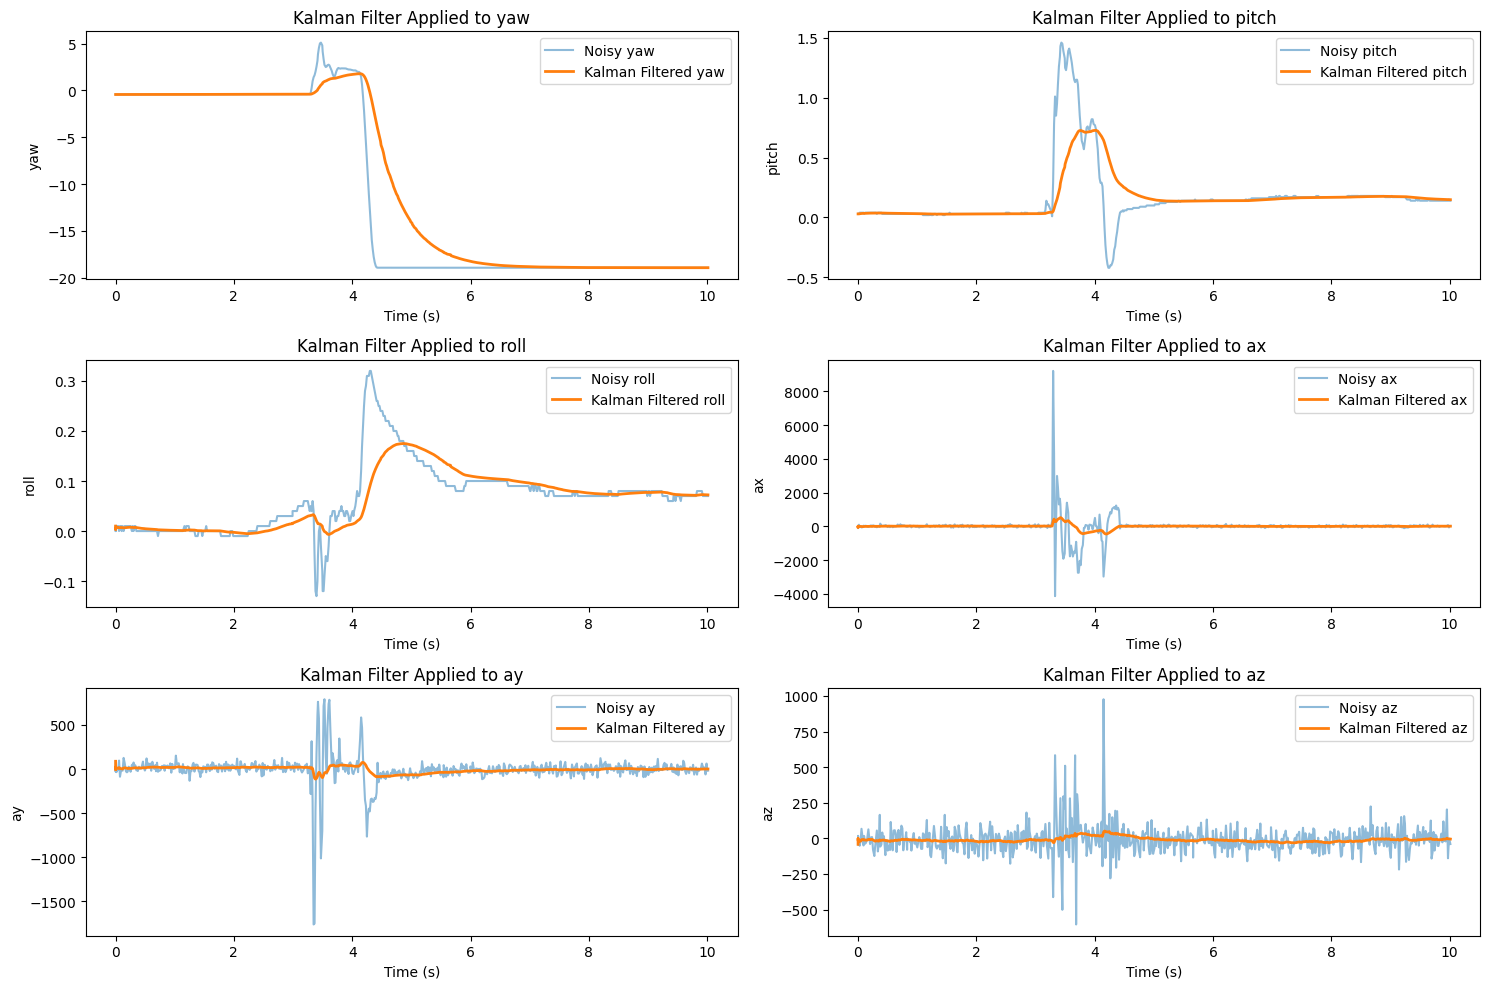

In [99]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_filter):
    plt.subplot(3, 2, i+1)
    plt.plot(df["timestamp"], df[col], label=f"Noisy {col}", alpha=0.5)
    plt.plot(filtered_kalman_df["timestamp"], filtered_kalman_df[col], label=f"Kalman Filtered {col}", linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel(col)
    plt.legend()
    plt.title(f"Kalman Filter Applied to {col}")

plt.tight_layout()
plt.show()

## Another Approach

In [100]:
def apply_median_filter(data, kernel_size=3):
    return signal.medfilt(data, kernel_size=kernel_size)


In [101]:
median_filtered_df = df.copy()
for col in columns_to_filter:
    median_filtered_df[col] = apply_median_filter(df[col].values, kernel_size=3)

## Adaptive kalman filter

In [102]:
def adaptive_kalman_filter(z, Q=1e-5, R=0.01, threshold_factor=3, initial_value=None):
    n_iter = len(z)
    xhat = np.zeros(n_iter)
    P = 1.0                   

    xhat[0] = z[0] if initial_value is None else initial_value
    
    robust_std = np.std(z)
    
    for k in range(1, n_iter):
        xhatminus = xhat[k-1]
        Pminus = P + Q

        innovation = z[k] - xhatminus

        if abs(innovation) > threshold_factor * robust_std:
            adaptive_R = R * 10  
        else:
            adaptive_R = R

        K = Pminus / (Pminus + adaptive_R)
        
        xhat[k] = xhatminus + K * innovation
        
        P = (1 - K) * Pminus

    return xhat

In [103]:
robust_filtered_df = df.copy()
for col in columns_to_filter:
    robust_filtered_df[col] = adaptive_kalman_filter(median_filtered_df[col].values,
                                                            Q=1e-5, R=0.01, threshold_factor=3)

robust_filtered_df.to_csv(output_file, index=False)

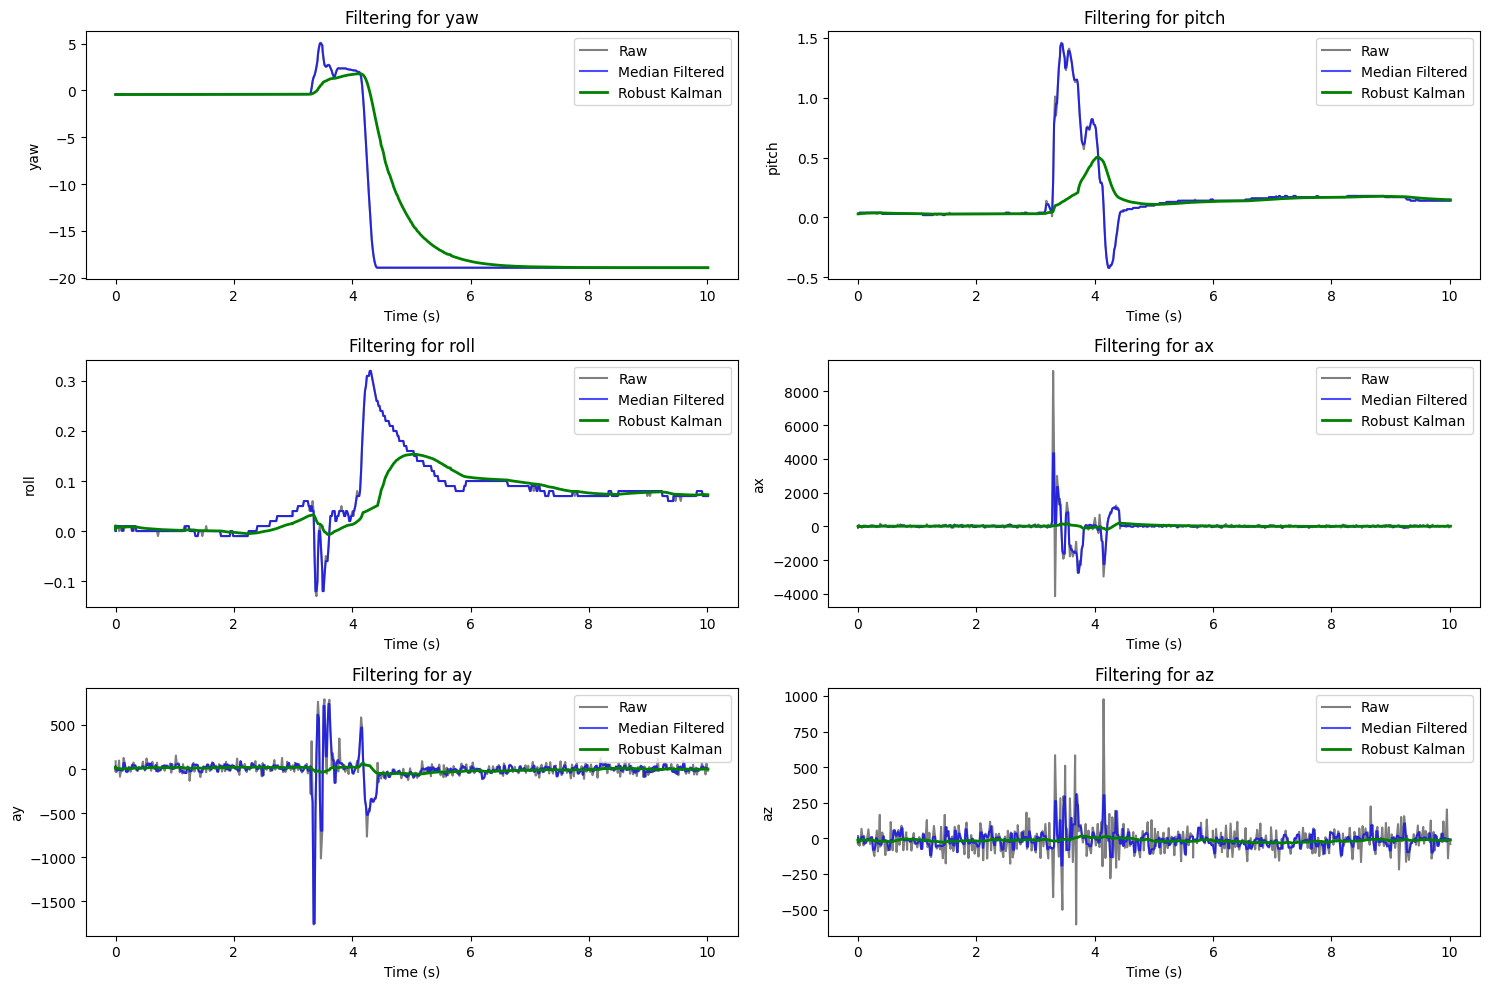

In [104]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_filter):
    plt.subplot(3, 2, i+1)
    plt.plot(df["timestamp"], df[col], label="Raw", alpha=0.5, c='black')
    plt.plot(median_filtered_df["timestamp"], median_filtered_df[col], label="Median Filtered", alpha=0.7, c='b')
    plt.plot(robust_filtered_df["timestamp"], robust_filtered_df[col], label="Robust Kalman", linewidth=2, c='g')
    plt.xlabel("Time (s)")
    plt.ylabel(col)
    plt.legend(loc='upper right')
    plt.title(f"Filtering for {col}")

plt.tight_layout()
plt.show()

In [105]:
# for col in columns_to_filter:
#     fig = px.line(df, x="timestamp", y=col, labels={"timestamp": "Time (s)", col: "Value"}, title=f"Filtering for {col}")

#     fig.add_scatter(x=median_filtered_df["timestamp"], y=median_filtered_df[col], mode="lines",
#                     name="Median Filtered", line=dict(color="blue", width=1))

#     fig.add_scatter(x=robust_filtered_df["timestamp"], y=robust_filtered_df[col], mode="lines",
#                     name="Robust Kalman", line=dict(color="green", width=2))

#     fig.add_scatter(x=df["timestamp"], y=df[col], mode="lines",
#                     name="Raw", line=dict(color="black", width=1, dash="dot"))

#     fig.show()
